первые строки данных:
   MaxAbsEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed        SPS  \
0           5.094096           0.387225        0.387225  0.417362  42.928571   
1           3.961417           0.533868        0.533868  0.462473  45.214286   
2           3.379111           0.543231        0.543231  0.260923  42.187500   
3           5.097360           0.390603        0.390603  0.377846  41.862069   
4           5.150510           0.270476        0.270476  0.429038  36.514286   

     MolWt  NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  \
0  384.652                  0.0          0.038844         -0.293526   
1  388.684                  0.0          0.012887         -0.313407   
2  446.808                  0.0          0.094802         -0.325573   
3  398.679                  0.0          0.038844         -0.293526   
4  466.713                  0.0          0.062897         -0.257239   

   FpDensityMorgan1  ...  fr_term_acetylene  fr_tetrazole  fr_thiazole

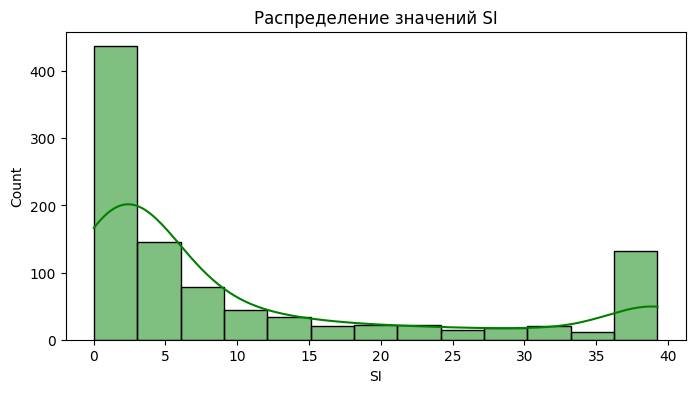


количество объектов в классах:
 SI
0    644
1    357
Name: count, dtype: int64


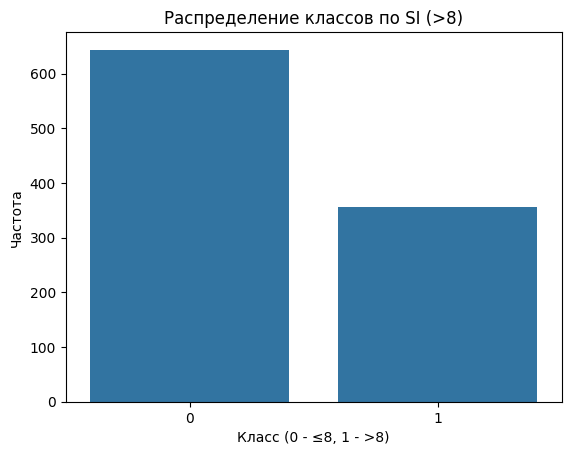

=== поиск лучших моделей ===


Logistic Regression — поиск гиперпараметров
Logistic Regression
Лучшие параметры: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       129
           1       1.00      0.99      0.99        72

    accuracy                           1.00       201
   macro avg       1.00      0.99      0.99       201
weighted avg       1.00      1.00      1.00       201

AUC-ROC: 0.9997

Random Forest — поиск гиперпараметров
Random Forest
Лучшие параметры: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       129
           1       0.83      0.62      0.71        72

    accuracy                           0.82       201
   macro avg       0.82      0.78      0.79       201
weighted avg       0.82      0.82      0.81       201

AUC-ROC: 0.9079

Gradient Boosti

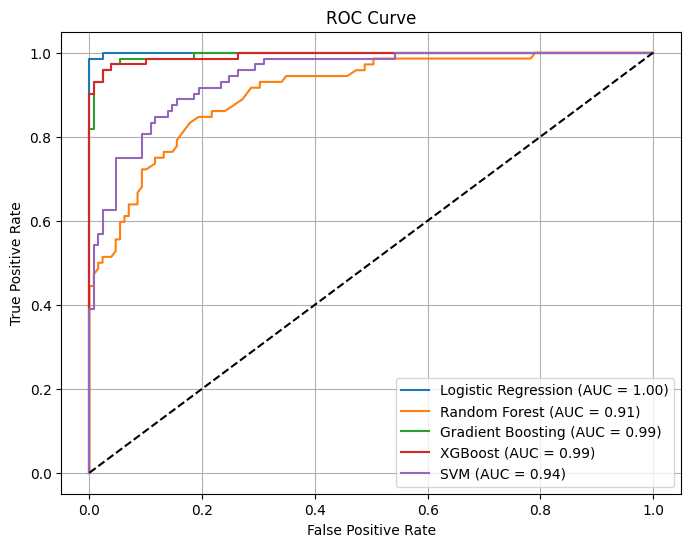

лучшая модель: Logistic Regression
метрика AUC-ROC: 0.9996770025839793


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve
import joblib

# загрузка данных
df = pd.read_csv("cleaned_data.csv")

# анализ данных
print("первые строки данных:")
print(df.head())
print("\nинформация о данных:")
print(df.info())

# целевая переменная — SI (последний столбец)
y_si = df.iloc[:, -1]

# распределение SI
plt.figure(figsize=(8,4))
sns.histplot(y_si, kde=True, color='green')
plt.title("Распределение значений SI")
plt.show()

# бинаризация по порогу 8
y_binary = (y_si > 8).astype(int)

# анализ дисбаланса классов
class_counts = y_binary.value_counts()
print("\nколичество объектов в классах:\n", class_counts)
sns.countplot(x=y_binary)
plt.title("Распределение классов по SI (>8)")
plt.xlabel("Класс (0 - ≤8, 1 - >8)")
plt.ylabel("Частота")
plt.show()

# разделение на признаки и целевую переменную
X = df.iloc[:, :-3]  # все признаки, кроме IC50 (-3), CC50 (-2), SI (-1)
X = pd.concat([X, df.iloc[:, -3:-1]], axis=1)  # добавляем IC50 и CC50

y = y_binary  # целевая переменная — SI > 8

# разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# стандартизация для SVM и некоторых моделей
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# модели и параметры для подбора гиперпараметров
model_pipelines = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            "C": [0.1, 1, 10],
            "penalty": ["l1", "l2"],
            "solver": ["liblinear"]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 5, 10],
            "min_samples_split": [2, 5]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "learning_rate": [0.01, 0.1, 0.2],
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 5]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0),
        "params": {
            "learning_rate": [0.01, 0.1, 0.2],
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 5],
            "subsample": [0.8, 1.0]
        }
    },
    "SVM": {
        "model": SVC(probability=True),  # Для ROC-AUC нужна вероятность
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["rbf", "poly"],
            "gamma": ["scale", "auto"]
        }
    }
}

# подбор гиперпараметров и оценка моделей
best_models = {}
f1_scores = {}
roc_auc_scores = {}

print("=== поиск лучших моделей ===\n")

for name, config in model_pipelines.items():
    print(f"\n{name} — поиск гиперпараметров")
    
    if name == "SVM":
        grid = GridSearchCV(config["model"], config["params"], scoring="f1", cv=5, n_jobs=-1)
        grid.fit(X_train_scaled, y_train)
        best_model = grid.best_estimator_
        pred = best_model.predict(X_test_scaled)
        probas = best_model.predict_proba(X_test_scaled)[:, 1]
    else:
        grid = GridSearchCV(config["model"], config["params"], scoring="f1", cv=5, n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        pred = best_model.predict(X_test)
        probas = best_model.predict_proba(X_test)[:, 1]

    report = classification_report(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, probas)
    
    print(f"{name}")
    print("Лучшие параметры:", grid.best_params_)
    print(report)
    print(f"AUC-ROC: {auc:.4f}")

    best_models[name] = best_model
    f1_scores[name] = f1
    roc_auc_scores[name] = auc

# определение лучшей модели
best_model_name = max(roc_auc_scores, key=roc_auc_scores.get)
best_model = best_models[best_model_name]

print("\nлучшая модель:")
print(f"{best_model_name} с AUC-ROC = {roc_auc_scores[best_model_name]:.4f}")

# ROC-кривая
plt.figure(figsize=(8,6))
for name, model in best_models.items():
    if name == "SVM":
        probas = model.predict_proba(X_test_scaled)[:, 1]
    else:
        probas = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probas)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_scores[name]:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# важность признаков
if hasattr(best_model, "feature_importances_"):
    feature_importance = best_model.feature_importances_
    features = X.columns
    importance_df = pd.DataFrame({"Feature": features, "Importance": feature_importance})
    importance_df = importance_df.sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=importance_df)
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()

# вывод результатов
print("лучшая модель:", best_model_name)
print("метрика AUC-ROC:", roc_auc_scores[best_model_name])